# Install and import dependencies

In [1]:
!git clone https://github.com/fionnfuchs/nolama-trading-bot

import sys
sys.path.append('/content/nolama-trading-bot/nolama')
sys.path.append('/content/nolama-trading-bot')

!pip install alpaca-trade-api
!pip install nest_asyncio
!pip install ta

Cloning into 'nolama-trading-bot'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 51 (delta 12), reused 40 (delta 7), pack-reused 0
Unpacking objects: 100% (51/51), done.
     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=49b10f0a96246ab3860d02f19f9e5473ed067bae37b6bcc29300c6fa64c74140
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [2]:
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import nest_asyncio

from nolama.bot import Bot
from nolama.steps import BollingerBandsCalculation, BollingerBandsScoring

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Ellipse

nest_asyncio.apply()

# Alpaca API (insert your keys here)

In [3]:
ALPACA_KEY = "PKQCV2R91BAY1D0X94HG"
ALPACA_SECRET = "vhPlO3UL35eSTUMwSDDofSJYctlZINco4dmnfQqP"

api = tradeapi.REST(ALPACA_KEY, ALPACA_SECRET, base_url='https://paper-api.alpaca.markets')
account = api.get_account()

# Run the bot

In [4]:
bot = Bot("AAPL", api)
bot.calculation_steps.append(BollingerBandsCalculation(window=30, window_dev=2))
bot.scoring_steps.append(BollingerBandsScoring())

In [5]:
import asyncio

# A timeframe when $AAPL price fell
falling_aapl = api.get_bars("AAPL", TimeFrame.Minute, "2021-01-26", "2021-02-26", limit=5000, adjustment='raw').df
# A timeframe when $AAPL price rose
rising_aapl = api.get_bars("AAPL", TimeFrame.Minute, "2021-01-21", "2021-02-24", limit=5000, adjustment='raw').df
# A timeframe when $AAPL price was relatively flat
flat_aapl = api.get_bars("AAPL", TimeFrame.Minute, "2020-11-11", "2020-11-13", limit=5000, adjustment='raw').df

# ---> Test the bot with one of the timeframes (for example flat_aapl):
# ---> Just set close to a list of closing prices and run this cell. Example lists are provided by the Alpaca API above.
close = flat_aapl["close"].tolist()

def run_test():
  for i in range (len(close)-1):
    bot.tick(close[i], i)

  holding_comparison = close[len(close)-1] - close[0]
  print("Profit of the bot: " + str(bot.performance))
  print("Profit when just holding for comparison: " + str(holding_comparison))

run_test()

Profit of the bot: 4.046300000000031
Profit when just holding for comparison: 1.75


# Plot the bots behaviour

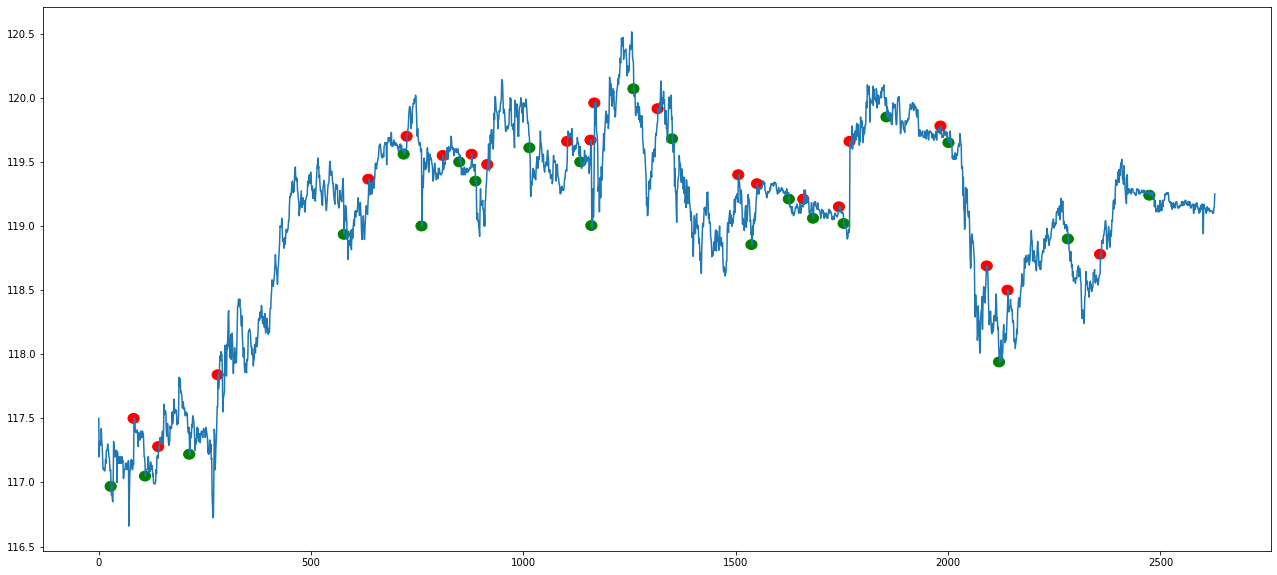

In [6]:
# Plot trades
# Green circles = buy, red circles = sell

trades = bot.trades

fig, ax = plt.subplots(figsize=(22,10))

ar = len(close) / (max(close)-min(close))
circle_radius = len(close)/100

for t in trades:
  color = "g"
  if t["type"] == "buy":
    color = "g"
  else:
    color = "r"
  circle = Ellipse((t["index"], t["price"]), width=circle_radius, height=circle_radius/ar*2, color=color)
  ax.add_patch(circle)

ax.plot(range(len(close)), close)